# HSV Example

This example demonstrates the use of `hsv` operation which manipulates the hue, saturation and value (brighness) aspects of the image.


## Introduction
### HSV Color Space
HSV represents colors by separating hue, saturation and brightness. In this color space, the hue is represented as an angle on the color circle. Saturation goes from 0 (greyscale) to 100% (fully saturated colors) and value goes from 0 (black) to 1 (full brightness). For details see:
[Wikipedia](https://en.wikipedia.org/wiki/HSL_and_HSV).

### A Note on Implementation
For performance reasons, DALI doesn't use the exact definition of HSV and approximates the operations in HSV space by linear (matrix) operations on RGB colors. This greatly improves performance at the cost of modest loss of fidelity.

## Step-by-Step Guide
1. Let's start from importing handful of utils and DALI itself.

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

batch_size = 10
image_filename = "../data/images"

Batch size is greater than one to facilitate switching between images at the end of the notebook.

2. Next, let's implement the pipeline. The decorated function `hsv_pipeline` can be used to create pipelines that process data on the CPU or the GPU, depending on the `device` argument. 

In [2]:
@pipeline_def()
def hsv_pipeline(device, hue, saturation, value):
    files, labels = fn.readers.file(file_root=image_filename)
    images = fn.decoders.image(
        files, device="cpu" if device == "cpu" else "mixed"
    )
    converted = fn.hsv(images, hue=hue, saturation=saturation, value=value)
    return images, converted

The function below is used to actually display result of HSV manipulation in DALI. Since the pipelines we set up return 2 outputs: modified image and original image, the function aquires both of them from the output and displays them. Additional flag (`cpu`) is specified, to determine, whether the pipeline output comes from CPU or GPU. In the latter case, we have to tell the output, to return a CPU-accessible copy of the data.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math


def display(outputs, idx, columns=2, captions=None, cpu=True):
    rows = int(math.ceil(len(outputs) / columns))
    fig = plt.figure()
    fig.set_size_inches(16, 6 * rows)
    gs = gridspec.GridSpec(rows, columns)
    row = 0
    col = 0
    for i, out in enumerate(outputs):
        plt.subplot(gs[i])
        plt.axis("off")
        if captions is not None:
            plt.title(captions[i])
        plt.imshow(out.at(idx) if cpu else out.as_cpu().at(idx))

3. Now let's just build the pipelines, run them and display the results. First the CPU one:

In [4]:
pipe_cpu = hsv_pipeline(
    device="cpu",
    hue=120,
    saturation=1,
    value=0.4,
    batch_size=batch_size,
    num_threads=1,
    device_id=0,
)
pipe_cpu.build()
cpu_output = pipe_cpu.run()

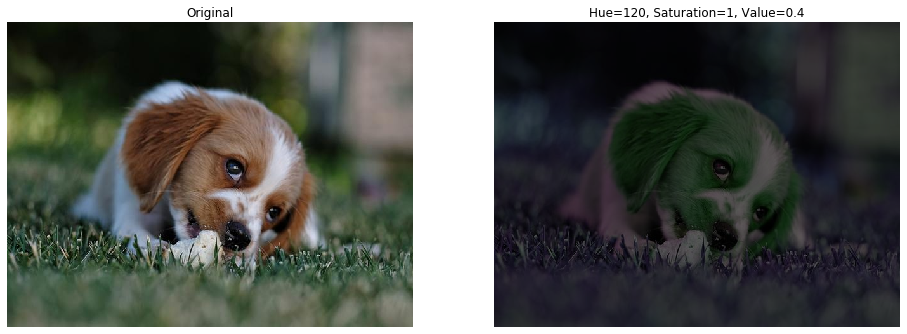

In [5]:
display(
    cpu_output, 3, captions=["Original", "Hue=120, Saturation=1, Value=0.4"]
)

4. And the GPU:

In [6]:
pipe_gpu = hsv_pipeline(
    device="gpu",
    hue=120,
    saturation=2,
    value=1,
    batch_size=batch_size,
    num_threads=1,
    device_id=0,
)
pipe_gpu.build()
gpu_output = pipe_gpu.run()

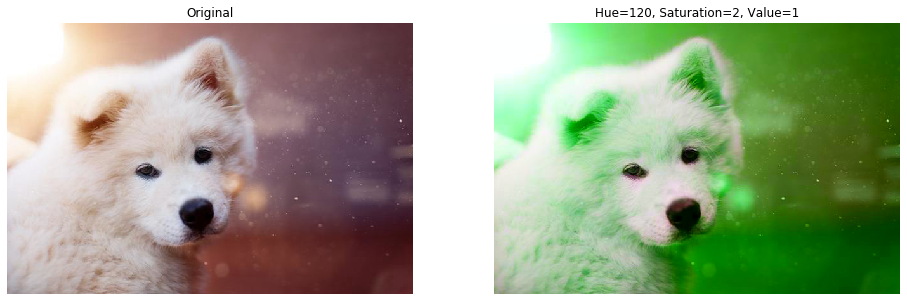

In [7]:
display(
    gpu_output,
    0,
    cpu=False,
    captions=["Original", "Hue=120, Saturation=2, Value=1"],
)

# Using HSV to implement RandomGrayscale operation

As a more interesting example of Hsv Operator, we would like to implement something similar to Pytorch's RandomGrayscale transformation - for a RGB input either convert it to grayscale image that still consists 3 channels (but with equal values) or pass it through unchanged.

To achieve the grayscale conversion, we will desaturate the input (set `saturation` to 0 for those samples). If we set the `saturation` to 1, the image will keep its colors. 

We can use `coin_flip` operation, that returns 0s and 1s with configurable probability. We will use the values generated by `coin_flip` to drive the `saturation` parameter of `hsv` operator. 

`coin_flip` generates a number for every sample in the processed batch that we can pass to the `saturation` argument in `hsv`. Because `coin_flip` returns integers and `hsv` expects floats as its parameters, we also need to convert those values using `cast`.

In [8]:
def random_grayscale(images, probability):
    saturate = fn.random.coin_flip(probability=1 - probability)
    saturate = fn.cast(saturate, dtype=types.FLOAT)
    return fn.hsv(images, saturation=saturate)


@pipeline_def(seed=422)
def random_grayscale_pipeline():
    files, labels = fn.readers.file(file_root=image_filename)
    images = fn.decoders.image(files, device="mixed")
    converted = random_grayscale(images, 0.6)
    return images, converted

Let's now build and run the pipeline.

In [9]:
pipe = random_grayscale_pipeline(
    batch_size=batch_size, num_threads=1, device_id=0
)
pipe.build()
output = pipe.run()

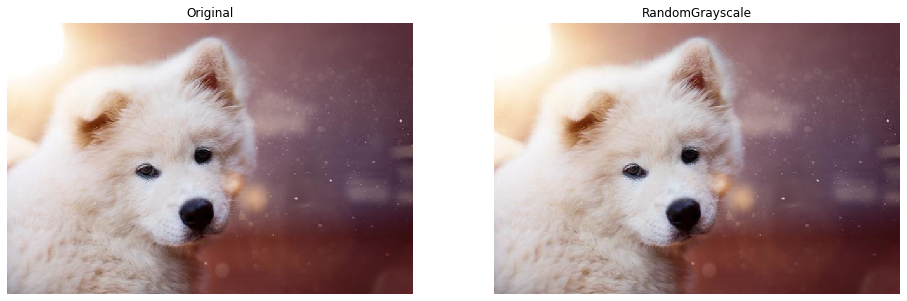

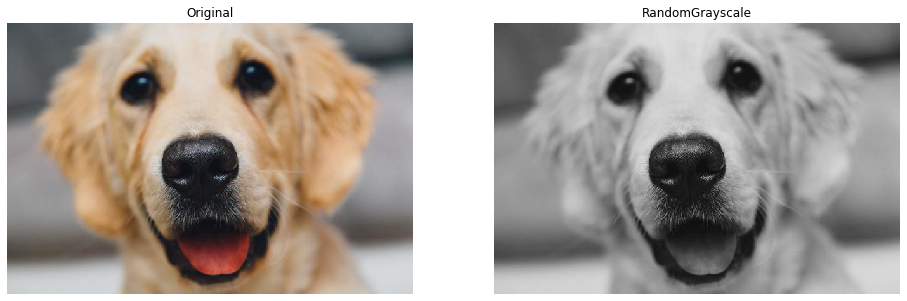

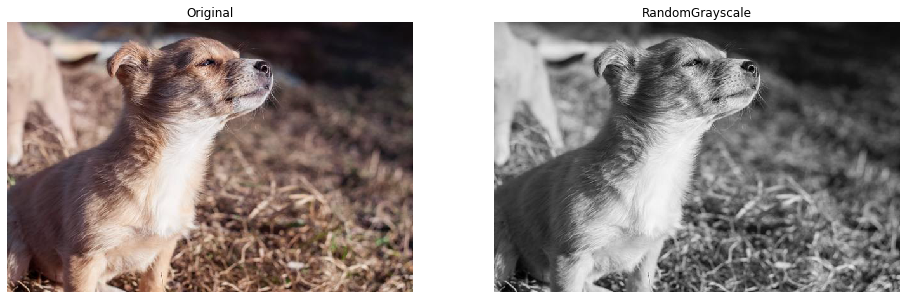

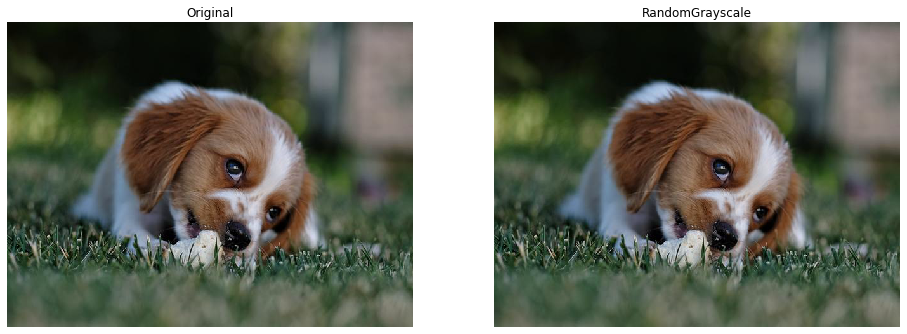

In [10]:
display(output, 0, cpu=False, captions=["Original", "RandomGrayscale"])
display(output, 1, cpu=False, captions=["Original", "RandomGrayscale"])
display(output, 2, cpu=False, captions=["Original", "RandomGrayscale"])
display(output, 3, cpu=False, captions=["Original", "RandomGrayscale"])